# FakeFinder: Upgrading the Expedition with Transfer Learning

Welcome, AI Explorer! It's time to upgrade our toolkit for the next leg of our journey. In the real world, explorers don't always build their vehicles from scratch; they often retrofit a powerful, pre-existing engine to achieve superior performance with greater efficiency. That is our mission in this assignment: to leverage the power of **transfer learning**.

We will harness the knowledge of a veteran model, **MobileNetV3-Large**, which has already been trained on the vast ImageNet dataset. By adapting this pre-trained model to our specific `AIvsReal` dataset, we will see a dramatic improvement in performance and speed.

Throughout this expedition, we will:

* Prepare our familiar image dataset with transformation pipelines optimized for pre-trained models.
* Understand the core principles of transfer learning and its pivotal role in modern computer vision.
* Load a powerful pre-trained model and adapt it for a new task using **feature extraction**.
* Freeze the convolutional base and replace the final classifier layer to specialize the model for fake image detection.
* Train our adapted model.

Get ready to see how leveraging pre-trained wisdom can accelerate our path to building highly effective, state of the art models.

<a name='0'></a>
## Imports

In [ ]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as tv_models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [ ]:
import helper_utils
import unittests

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

Using Device: cuda


<a name='1'></a>
## 1 - Preparing for the Next Expedition: A Quick Reconnaissance

We are using the curated collection of images from the [AI-Generated Images vs Real Images](https://www.kaggle.com/datasets/tristanzhang32/ai-generated-images-vs-real-images) dataset.

This dataset is a sample from a larger collection of 60,000 images. Half are generated by advanced AI models (Stable Diffusion, MidJourney, and DALL·E), and the other half are genuine images from sources like Pexels and Unsplash. we will work with the same carefully selected subset of **5,000 images for training** and **1,000 for testing/validation**.

 Images are sorted into `train` and `test` folders, each containing `real` and `fake` subdirectories. This logical structure is fundamental to understand, as it directly influences how we will load the data for the upcoming tasks.

Here’s the data layout:

```
./AIvsReal_sampled/
└───train/
|   ├───fake/
|   │   ├───0046.jpg
|   │   └───...
|   └───real/
|       ├───0046.jpg
|       └───...
└───test/
    ├───fake/
    │   ├───0046.jpg
    │   └───...
    └───real/
        ├───0046.jpg
        └───...
```

* Run the next two cells to define the path to the dataset and view some samples from the training folder.

In [ ]:
# Load the dataset path
dataset_path = "./AIvsReal_sampled"

# Analyzes the dataset splits at the given path and prints a count of images for each class.
helper_utils.dataset_images_per_class(dataset_path)

Analyzing dataset at: ./AIvsReal_sampled

— Train —
Fake: 2500 images
Real: 2500 images

— Test —
Fake: 500 images
Real: 500 images



**Note**: For the remainder of this expedition, we will use the `test` directory as our **validation set**.

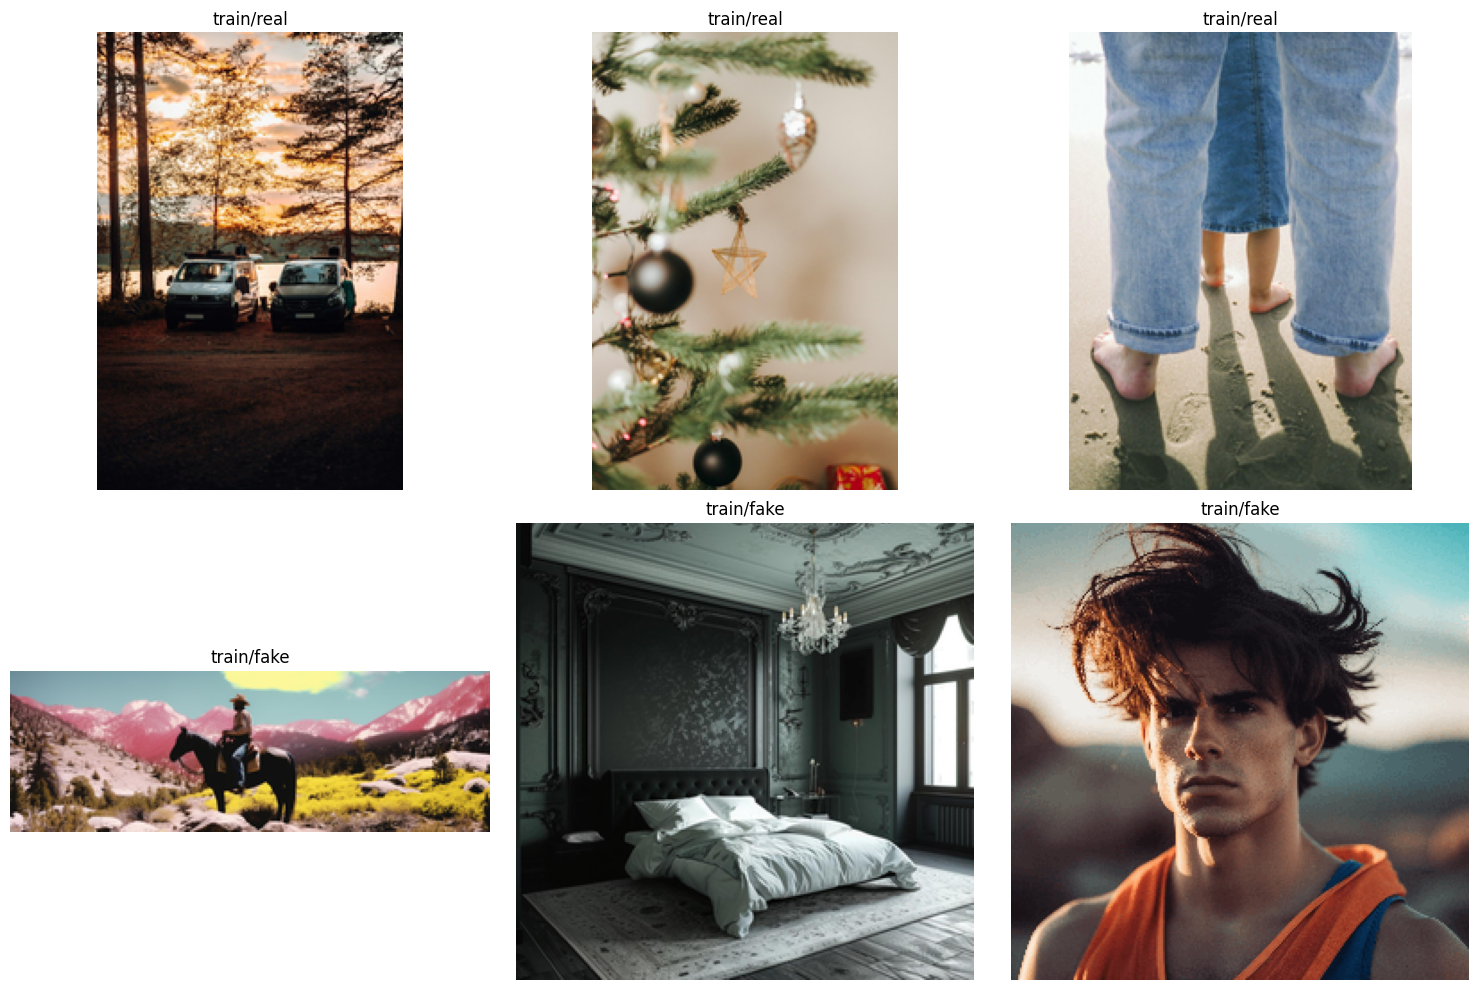

In [ ]:
# Randomly select and display a grid of sample images from the 'train' folder.
helper_utils.display_train_images(dataset_path)

<a name='1-1'></a>
### 1.1 - Scouting the Archives: Loading Data with ImageFolder

Now that we've reviewed the dataset, our next objective is to load the images into a structure that PyTorch can use for training. For datasets that are neatly organized into subdirectories for each class, such as our `AIvsReal_sampled` data, `ImageFolder` is an exceptionally convenient and standard tool.

This tool works by automatically inferring class labels from the names of the subdirectories. It expects our data to be arranged such that `dataset_path/class_name/image_name.jpg` would be an image belonging to `class_name`. This feature aligns perfectly with our dataset's organized structure, saving we significant preparation time.

A pivotal advantage of `ImageFolder` is its `transform` attribute. This allows us to apply a sequence of image transformations, giving us precise control over how our data is prepared. we have the flexibility to set these transformations when we first load the data or apply them later. This adaptability ensures our data loading pipeline is highly effective and reusable for future projects.

<a name='ex-1'></a>

**our Task**:

* Use the [ImageFolder](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) class to create a dataset object for our training data and another for our validation data.
* The paths for the training and validation directories (`train_path` and `val_path`) have already been defined for we. we'll need to pass the correct path to each `ImageFolder` instance.
* The function should return the two datasets we create: `train_dataset` and `val_dataset`.



In [ ]:
# GRADED FUNCTION: create_dataset_splits

def create_dataset_splits(data_path):
    """
    Creates training and validation datasets from a directory structure using ImageFolder.

    Args:
        data_path (str): The root path to the dataset directory, which should
                         contain 'train' and 'validation/test' subdirectories.

    Returns:
        tuple: A tuple containing the train_dataset and validation_dataset
               (train_dataset, validation_dataset).
    """

    # Construct the full path to the training data directory.
    train_path = data_path + "/train"
    # Construct the full path to the validation data directory.
    val_path = data_path + "/test"

    ### START CODE HERE ###

    # Create the train dataset using ImageFolder
    train_dataset = ImageFolder(
        # Set the root to train dataset path
        root=train_path,
    )

    # Create the validation dataset using ImageFolder
    val_dataset = ImageFolder(
        # Set the root to validation dataset path
        root=val_path,
    )

    ### END CODE HERE ###

    return train_dataset, val_dataset

In [ ]:
# Verify that the function loads the datasets
temp_train, temp_val = create_dataset_splits(dataset_path)

print("--- Training Dataset ---")
print(temp_train)
print("\n--- Validation Dataset ---")
print(temp_val)

--- Training Dataset ---
Dataset ImageFolder
    Number of datapoints: 5003
    Root location: ./AIvsReal_sampled/train

--- Validation Dataset ---
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: ./AIvsReal_sampled/test


In [ ]:
# Test our code!
unittests.exercise_1(create_dataset_splits)

 All tests passed!


<a name='1-2'></a>
### 1.2 - Specialized Augmentations: Protocols for Training and Validation

Now it's time to define the transformations that will prepare our images for the neural network. These preprocessing steps are pivotal for standardizing our data and for augmenting the training set to make our model more robust.

When using pre-trained architectures as we will later, it's standard practice to apply *different* sets of transformations to our training and validation datasets. When leveraging a pre-trained model, it is **essential** that the core transformations applied to both our training and validation data are identical to the ones used to train the original model. This is particularly important for resizing the images and using the same normalization values (mean and standard deviation). While data augmentation techniques can vary between our training and validation data, these fundamental steps ensure our data is processed in a way the pre-trained model already understands.

* Before jumping into the transformations, we'll first define the standard normalization values from the ImageNet dataset, on which many pre-trained models were trained.

In [ ]:
# Define the standard mean values for the ImageNet dataset
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])

# Define the standard standard deviation values for the ImageNet dataset
imagenet_std = torch.tensor([0.229, 0.224, 0.225])


**our Task**:

* **For the `train_transform` pipeline:**
    * we need to chain together a series of transformations using [transforms.Compose](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html).
    * This pipeline should include operations for:
        *  [Random resizing](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html).
        *  [Random horizontal flipping](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html).
        *  [Color adjustments](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html) to augment the data.
        *  [Tensor conversion](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html).
        *  [Normalization](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html).
>
* **For the `val_transform` pipeline:**
    * Create a second `transforms.Compose` pipeline.
    * This one will be simpler and should only include the essential steps:
        * [Resizing](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) the image.
        * [Tensor conversion](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html).
        * [Normalization](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html).
>
* Both pipelines should use the `mean` and `std` values passed into the function for normalization.



In [ ]:
# GRADED FUNCTION: define_transformations

def define_transformations(mean=imagenet_mean, std=imagenet_std):
    """
    Defines separate series of image transformations for training and validation datasets.

    Args:
        mean (list or tuple): The mean values (for each channel, e.g., RGB) calculated from ImageNet.
        std (list or tuple): The standard deviation values (for each channel) calculated from ImageNet.

    Returns:
        tuple: A tuple containing two `torchvision.transforms.Compose` objects:
               - The first for training transformations.
               - The second for validation transformations.
    """

    ### START CODE HERE ###

    # Create a Compose object to chain multiple transformations together for the training set

    # Initialize 'train_transform' using transforms.Compose to apply a sequence of transforms
    train_transform = transforms.Compose([
        # Randomly resize and crop the input image to 224x224 pixels
        transforms.RandomResizedCrop((224,224)),

        # Apply a random horizontal flip to the image for data augmentation
        transforms.RandomHorizontalFlip(),

        # Randomly change the brightness and contrast of the image for data augmentation
        # Set `brightness=0.2` and `contrast=0.2`
        transforms.ColorJitter(brightness=0.2,contrast=0.2),

        # Convert the PIL Image to a PyTorch Tensor
        transforms.ToTensor(),

        # Normalize the tensor image with the provided 'mean' and 'std' to normalize the tensor
        transforms.Normalize(mean=mean,std=std),
    ])

    # Create a Compose object to chain multiple transformations together for the validation set

    # Initialize 'val_transform' using transforms.Compose to apply a sequence of transforms
    val_transform = transforms.Compose([
        # Resize the input image to to 224x224 pixels
        transforms.Resize((224,224)),

        # Convert the PIL Image to a PyTorch Tensor
        transforms.ToTensor(),

        # Normalize the tensor image with the provided 'mean' and 'std' to normalize the tensor
        transforms.Normalize(mean=mean,std=std),
    ])

    ### END CODE HERE ###

    return train_transform, val_transform

In [ ]:
# Create the composed transformations
combined_transformations = define_transformations()

# Print the composed transformations to verify the sequence of operations
print("Augmented Training Transformations:\n")
print(combined_transformations[0])
print("\nValidation Transformations:\n")
print(combined_transformations[1])

Augmented Training Transformations:

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Validation Transformations:

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


In [ ]:
# Test our code!
unittests.exercise_2(define_transformations)

 All tests passed!


<a name='1-3'></a>
### 1.3 - Preparing the Data Launchpad: Applying Transformations and Batching Data

we have now handled the creation of our training and validation dataset objects and separately defined the transformation pipelines for each. A powerful feature of the `ImageFolder` objects is their built-in `.transform` attribute. we'll now apply our defined transformations by assigning each pipeline to its respective dataset. This provides a clean and modular way to prepare each data subset for its specific purpose. After this, we'll use `DataLoader` to create batched and shuffled data loaders for our training and validation data, which is an essential step to prepare it for training.

**our Task**:

* **Retrieve Transformations**:
    * Call the `define_transformations()` function we implemented earlier to get the `train_transform` and `val_transform` pipelines.
>
* **Apply Transformations**:
    * Assign the `train_transform` to the `.transform` attribute of the input `trainset`.
    * Assign the `val_transform` to the `.transform` attribute of the input `valset`.
>
* **Create DataLoaders**:
    * Instantiate a [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training set. Remember to shuffle the training data.
    * Instantiate a second `DataLoader` for the validation set. This one should not be shuffled.
>
* Both `DataLoader` instances should use the `batch_size` provided to the function.



In [ ]:
# create_data_loaders

def create_data_loaders(trainset, valset, batch_size):
    """
    Creates DataLoader instances for training and validation datasets with respective transformations.

    Args:
        trainset (torch.utils.data.Dataset): The training dataset.
        valset (torch.utils.data.Dataset): The validation dataset.
        batch_size (int): The number of samples to load in each batch.

    Returns:
        tuple: A tuple containing:
            - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
            - val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
            - trainset (torch.utils.data.Dataset): The original training dataset with transformations now applied.
            - valset (torch.utils.data.Dataset): The original validation dataset with transformations now applied.
    """

    # Define separate transformations for the training and validation datasets
    # Use define_transformations() to get train_transform and val_transform
    train_transform, val_transform = define_transformations()

    # Apply the train transformations directly to the train dataset by setting the .transform attribute
    trainset.transform = train_transform
    # Apply the val transformations directly to the val dataset by setting the .transform attribute
    valset.transform = val_transform

    # Create a DataLoader for the training dataset
    # Use the transformed train dataset
    # Set batch_size to the input batch_size
    # Set shuffle=True
    train_loader = DataLoader(dataset=trainset,
                             batch_size=batch_size,
                             shuffle=True)

    # Create a DataLoader for the validation dataset
    # Use the transformed validation dataset
    # Set batch_size to the input batch_size
    # Set shuffle=False
    val_loader  = DataLoader(dataset=valset,
                            batch_size=batch_size,
                            shuffle=False)


    return train_loader, val_loader, trainset, valset

In [ ]:
dataloaders = create_data_loaders(temp_train, temp_val, batch_size=16)

print("--- Train Loader ---")
helper_utils.display_data_loader_contents(dataloaders[0])
print("\n--- Val Loader ---")
helper_utils.display_data_loader_contents(dataloaders[1])

--- Train Loader ---
Length: 313
--- Batch 1 ---
Data shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])

--- Val Loader ---
Length: 63
--- Batch 1 ---
Data shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


In [ ]:
# Test our code!
unittests.exercise_3(create_data_loaders)

 All tests passed!


<a name='2'></a>
## 2 - Advanced Expedition: Leveraging Pre-trained Model Wisdom

we’ve prepared our data. Now, it's time for the heart of this expedition: selecting and working with a **pre-trained model**. This approach, known as **transfer learning**, is a cornerstone of modern computer vision.

Instead of building a model from scratch, we can leverage a model that has already learned from a massive and diverse dataset, such as ImageNet. Think of it as using a powerful, veteran tool already equipped with a deep understanding of general visual patterns.

The benefits of this approach are substantial:

* **Accelerated Discovery**: we get a significant head start, as the model has already learned a rich set of features.
* **Superior Performance**: Pre-trained models often achieve higher accuracy, especially when our dataset is small.

<a name='2-1'></a>
### 2.1 - Selecting our Champion: Introducing MobileNetV3-Large

our first task in this phase is to choose a suitable pre-trained architecture. For this assignment, we'll be working with [MobileNetV3-Large](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html), an efficient and powerful model.

**Why MobileNetV3-Large?**

It’s an excellent choice for a task like identifying AI-generated images due to its:

* **High Efficiency**: It offers an outstanding trade-off between accuracy and resource usage, making it highly suitable for performance on resource-constrained environments.
* **Strong Classification Accuracy**: Despite its focus on efficiency, MobileNetV3-Large delivers robust performance, incorporating advanced design elements optimized through Neural Architecture Search (NAS).
* **Effective Feature Extraction**: Having been pre-trained on the massive ImageNet dataset, the model has already learned a rich hierarchy of visual features, a strong foundation we can adapt to distinguish between real and fake images.

**our Task**:

* **Load the Model Architecture**:
    * Instantiate a [**`mobilenet_v3_large`**](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html) model from `torchvision.models`.
    * It's essential to initialize it **without** its pre-trained weights (`weights=None`)  for now (we'll load them in the next step).
>
* **Load the Weights**:
    * Use **`torch.load()`** to load the model's state dictionary (its weights) from the `weights_path` provided to the function.
>
* The rest of the function, which applies these loaded weights to the model architecture, is already completed for we.



In [ ]:
# load_mobilenetv3_model

def load_mobilenetv3_model(weights_path):
    """
    Loads a pre-trained MobileNetV3-Large model from torchvision.

    Args:
        weights_path (str): The file path to the saved .pth model weights.

    Returns:
        torch.nn.Module: A pre-trained MobileNetV3-Large model.
    """

    # Load the pre-trained MobileNetV3-Large model without pre-trained weights.
    model = tv_models.mobilenet_v3_large(weights=None)

    # Load the state dictionary (weights) from the local file.
    state_dict = torch.load(weights_path, map_location=torch.device('cpu'))

    model.load_state_dict(state_dict)

    return model

In [ ]:
# Load the pre-trained MobileNetV3-Large model using weights from the local file.
local_weights = "./mobilenet_weights/mobilenet_v3_large-8738ca79.pth"
test_model = load_mobilenetv3_model(local_weights)

# Print the last layer of the classifier of the loaded model
print(test_model.classifier[-1])

Linear(in_features=1280, out_features=1000, bias=True)


In [ ]:
# Test our code!
unittests.exercise_4_1(load_mobilenetv3_model)

 All tests passed!


<a name='2-2'></a>
### 2.2 - Tailoring our Champion: Adapting MobileNetV3 for Fake Detection

we've selected our champion: the pre-trained `MobileNetV3-Large` model. While it's a veteran at classifying images from the vast ImageNet dataset (with 1,000 classes), it needs to be tailored for our specific mission of identifying AI-generated images, which has only two classes. This process is called **feature extraction**.

To adapt the model, we will follow two pivotal steps:

* **Freezing the Core Layers**: The early layers of the model, which are responsible for extracting general visual patterns like edges, textures, and shapes, contain invaluable knowledge. By **freezing** these layers, we prevent their weights from being updated during training. This preserves the model's powerful foundation, significantly reduces the number of trainable parameters, and accelerates training.

* **Replacing the Classifier Head**: The original model's final classifier is configured for 1,000 classes and is not suitable for our two-class task. we'll replace it with a new, custom-built classifier. This new layer will take the high-level features from the frozen core and output a prediction for our two target classes, preparing our model to become a specialized FakeFinder.


**our Task**:

* **Freeze Feature Layers**:
    * The pre-trained knowledge of the model is in its feature layers (`model.features`). we need to **freeze** these layers to prevent them from being updated during training.
    * To do this, we will iterate through all the parameters in `model.features.parameters()` and set their `requires_grad` attribute to `False`.
>
* **Replace the Classifier Head**:
    * The original classifier (`model.classifier[-1]`) is designed for 1,000 classes. we need to replace it with a new one suited for our task.
    * we will need to get the number of input features from the original classifier.
    * Then, create a new [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer with the correct number of input features and the new `num_classes` as the output.
    * Finally, replace the old classifier with our new one.
>



In [ ]:
# update_model_last_layer

def update_model_last_layer(model, num_classes):
    """
    Freezes the feature layers of a pre-trained model and replaces its final
    classification layer with a new one adapted to the specified number of classes.

    Args:
        model (torch.nn.Module): The pre-trained model to be modified.
        num_classes (int): The number of output classes for the new classification layer.

    Returns:
        torch.nn.Module: The modified model with frozen feature layers and a new
                         classification layer.
    """

    # Freeze the parameters of the feature layers of the model
    # Iterate through each parameter in model.features.parameters()
    for feature_parameter in model.features.parameters():
        # Set the requires_grad attribute of each feature_parameter to False
        feature_parameter.requires_grad = False

    # Access the final classification layer of the model
    last_classifier_layer = model.classifier[-1]

    # Access the in_features attribute of last_classifier_layer
    num_features = last_classifier_layer.in_features

    # # Use nn.Linear to create a new Linear layer for classification with the original number of
    # input features and the specified number of output classes
    new_classifier = nn.Linear(in_features=num_features, out_features=num_classes)

    # Replace the original last classification layer with the newly created layer
    model.classifier[-1] = new_classifier


    return model

In [ ]:
# Modify the last layer of the MobileNetV3-Large model
test_model = update_model_last_layer(test_model, num_classes=5)

# Print the last layer of the classifier of the modified model
print(test_model.classifier[-1])

Linear(in_features=1280, out_features=5, bias=True)


In [ ]:
# Test our code!
unittests.exercise_4_2(update_model_last_layer)

 All tests passed!


<a name='3'></a>
## 3 - Final Expedition: Training and Evaluating our Adapted Champion

This section allows we to take our adapted MobileNetV3 model through a training cycle and observe its performance. It's a chance to see how the harnessed knowledge from a pre-trained model, combined with our specialized techniques, leads to a powerful FakeFinder.

<a name='3-1'></a>
### 3.1 - Setting the Launchpad: Preparing DataLoaders and the Adapted Model

Before we can begin the actual training, we first need to set up our environment by executing three core steps:

* **Initializing the Datasets**: we'll first load our training and validation data from their respective directories.

* **Initializing the DataLoaders**: Next, we'll create the `train_loader` and `val_loader` to feed our transformed images to the model in manageable batches.

* **Preparing the Model**: we'll load the pre-trained MobileNetV3-Large model and then adapt its final classification layer for our two specific classes. This readies our champion model for its specialized mission.

The following code cell will execute these preparatory steps, ensuring both our data and our model are primed for the training loop.

In [ ]:
# Initialize the training and validation datasets
train_dataset, val_dataset = create_dataset_splits(dataset_path)

# Initialize the dataloaders for training and validation
train_loader, val_loader, _, __ = create_data_loaders(train_dataset, val_dataset, batch_size=32)

In [ ]:
# Load the pre-trained MobileNetV3-Large model and modify its last layer
local_weights = "./mobilenet_weights/mobilenet_v3_large-8738ca79.pth"
mobilenet_model = load_mobilenetv3_model(local_weights)
mobilenet_model = update_model_last_layer(mobilenet_model, num_classes=2)

<a name='3-2'></a>
### 3.2 - Training the Adapted Model

With our data prepared and the MobileNetV3 model adapted, it's time to fine-tune its layers on our AI vs. Real image dataset. This training step will prepare the model to become a specialized FakeFinder.

* Define the loss function and the optimizer.
    * The optimizer will only update the unfrozen layers of the model, which in this case, is just the new classifier head.

In [ ]:
# Define the loss function to compute the difference between the model's output and the true labels
loss_fcn = nn.CrossEntropyLoss()

# Define the optimizer to update the model's weights during training
optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                             mobilenet_model.parameters()),
                       lr=0.001)

* Define the number of epochs for training.
    * we can experiment by adjusting this number to observe different training results, but for now, run it for just one epoch to see the powerful results of a pre-trained model.

In [ ]:
# Set the number of epochs
num_epochs = 5

* Use the `training_loop` helper function to manage the standard training and validation cycle, a process that should be familiar to we by now.

In [ ]:
# Train the model
trained_model = helper_utils.training_loop(
    mobilenet_model,
    train_loader,
    val_loader,
    loss_fcn,
    optimizer,
    DEVICE,
    num_epochs
)

Epoch 1/5 Training:   0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 1/5 Validating:   0%|          | 0/32 [00:00<?, ?batch/s]

Val Loss (Avg): 0.3597, Val Accuracy: 85.60%

New best model saved to ./best_model_saved/best_model.pth with Val Accuracy: 85.60%



Epoch 2/5 Training:   0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 2/5 Validating:   0%|          | 0/32 [00:00<?, ?batch/s]

Val Loss (Avg): 0.3201, Val Accuracy: 86.80%

New best model saved to ./best_model_saved/best_model.pth with Val Accuracy: 86.80%



Epoch 3/5 Training:   0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 3/5 Validating:   0%|          | 0/32 [00:00<?, ?batch/s]

Val Loss (Avg): 0.3321, Val Accuracy: 85.50%



Epoch 4/5 Training:   0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 4/5 Validating:   0%|          | 0/32 [00:00<?, ?batch/s]

Val Loss (Avg): 0.3543, Val Accuracy: 84.40%



Epoch 5/5 Training:   0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 5/5 Validating:   0%|          | 0/32 [00:00<?, ?batch/s]

Val Loss (Avg): 0.2827, Val Accuracy: 87.60%

New best model saved to ./best_model_saved/best_model.pth with Val Accuracy: 87.60%


Training ended. Best trained model returned.
Best Val Accuracy: 87.60%
Best Val Precision: 0.8760
Best Val Recall: 0.8760



<br>

With the training complete, it’s now time to reflect on the remarkable improvements we've just observed.

By simply leveraging a pre-trained MobileNetV3-Large model and doing feature extraction, we have reached a validation accuracy and precision of over **80%** in just **1 epoch**! This is a dramatic performance gain in a fraction of the time.

This difference powerfully illustrates a fundamental lesson in machine learning: a pre-trained model's extensive knowledge base provides an accelerated path to superior performance. While building custom architectures is pivotal for understanding how deep learning works, knowing when and how to apply the wisdom of pre-trained models is how we conquer complex, real world missions with unparalleled speed and efficiency.

<a name='3-3'></a>
### 3.3 - Performance Review: Visualizing Predictions

our adapted model has completed its training. While the final accuracy score gives we a quantitative measure of its performance, it's often more insightful to see the model in action. In this final section, we'll conduct a qualitative review of our upgraded FakeFinder.

First, we will visualize the model's predictions on a random batch of images from the validation set. This will help we get a feel for where the model succeeds and where it might make errors, providing a clearer picture than numbers alone.



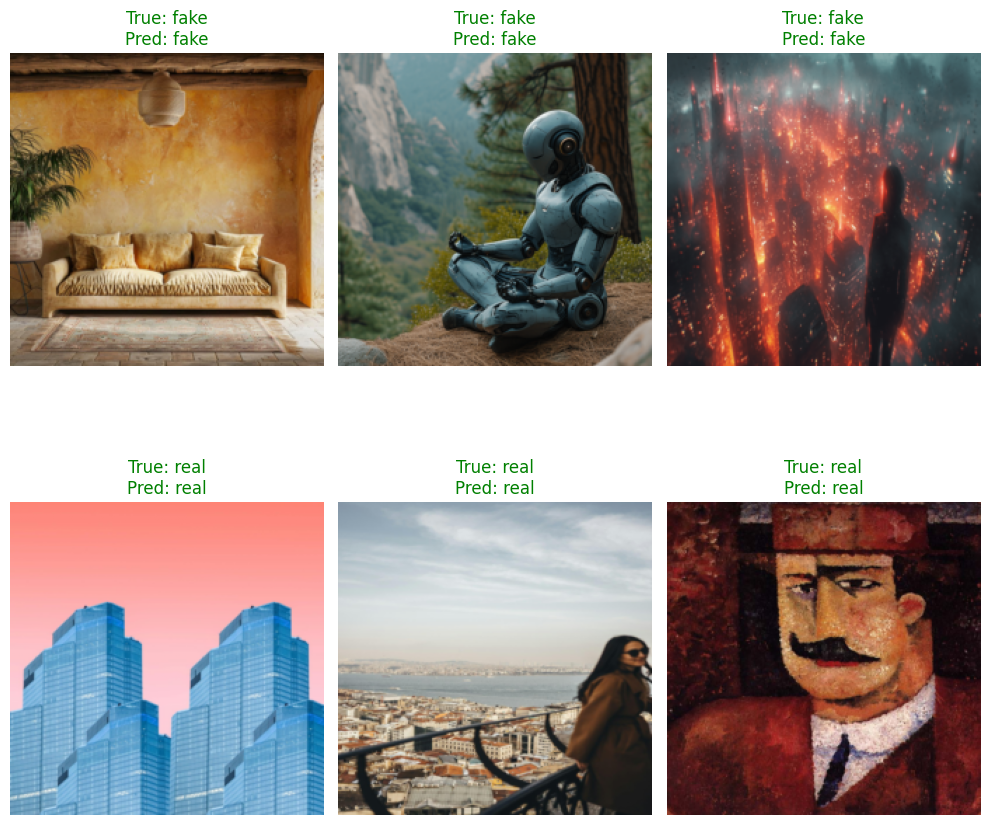

In [ ]:
# Get the list of class names ('fake', 'real') from the validation dataset.
class_names = val_dataset.classes

# Visualise predictions made by the trained model
helper_utils.visualize_predictions(trained_model, val_loader, DEVICE, class_names)

#### Test our FakeFinder on a New Image

Now it's time to put our FakeFinder to the test with a new piece of data. we can upload our own image to see how the model classifies it. This is a great way to test its performance on data it has never seen.

Run the `helper_utils.upload_jpg_widget()` function, which displays a widget for uploading images directly into the workspace. Please note the following:

* we can only upload images that have a `.jpg` extension.
* The file size for the image should not exceed **5 MB**.
* After a successful upload, the image's file path will be displayed. we should copy this path for the next step.
* Once the widget is displayed, we can use it multiple times to upload images; we don't have to re-run the `helper_utils.upload_jpg_widget()` function.

In [ ]:
helper_utils.upload_jpg_widget()

FileUpload(value=(), accept='.jpg', description='Upload JPG (Max 5MB)')

Output()

* Set the path to our image (as displayed above).

Alternatively, we can use these images that are already present in the workspace:
> * `image_path = './images/fake/birds_sheep_dog.jpg'`
> * `image_path = './images/fake/car_bus_tram.jpg'`
> * `image_path = './images/fake/person_and_bicycle.jpg'`
> * `image_path = './images/real/eiffel_tower.jpg'`
> * `image_path = './images/real/minar.jpg'`
> * `image_path = './images/real/statue_liberty.jpg'`


* A default path has been set for we, but feel free to change it to a different one.

In [ ]:
# EDITABLE CELL:

image_path = './images/my_pic.jpg' ### Add our image path here

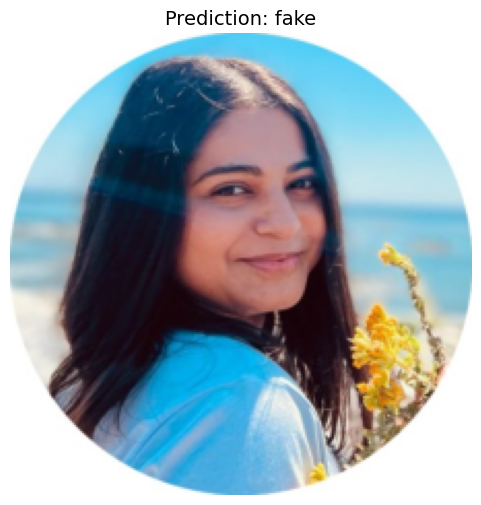

In [ ]:
# Display a prediction for the single uploaded image.
helper_utils.make_predictions(trained_model, image_path, DEVICE, class_names)